<a href="https://colab.research.google.com/github/alirempel/cap-comp215/blob/main/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Circle Simulation
### Author: Alison R
### Date: 2024-02-05

ADD DESCRIPTION OF PROJECT HEREEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

Below are the imported modules, and brief descriptions of where they were used for the less self explanatory modules

In [373]:
import matplotlib.pyplot as plt
import math
import itertools # for checking circle collisions
import matplotlib.patches # for drawing circles

# for animation method in
import time
from matplotlib import animation
from IPython.display import clear_output



###Below are the customizable variables:
* *X* is the size you would like the width of the window of the simulation to be (must be positive INT, recommended below 150 for best viewing without needing to zoom out)
* *Y* is the size you would like the height of the window of the simulation to be (must be positive INT, recommended below 50 for best viewing without needing to zoom out)
* *num_circles* is the number of circles you would like in the simulation (must be an INT)

  **IMPORTANT NOTE: The below variables are <u>lists</u>, and the length must be the same as num_circles**
* *circle_radii* is a list of the sizes of each circle's radius (each entry must be an INT)
* *circle_positions* is a list of the starting positions for each circle (each entry must be a **TUPLE** with 2 INTs and within the window size)
* *circle_directions* is a list of the circle's directions as angles (each entry must be an INT between 0 and 360)



In [374]:
X = 50
Y = 50

num_circles = 3

circle_radii = [5,5,5]
circle_positions = [(45,40),(30,10),(30,20)]
circle_directions = [45,90,270]
interval = .1

In [375]:

class Circle:
    """ Representation for the data and operations on a circle """

    def __init__(self, radius:float, centre:tuple, direction:int):
      assert len(centre) == 2
      self.radius = radius
      self.centre = centre
      self.direction = direction # angle its heading (degs)
      self.x = round(math.cos(math.radians(direction)),2) # how much to move in the x axis each step
      self.y = round(math.sin(math.radians(direction)),2) # how much to move in the y axis each step

    def __str__(self):
      """ Show the radius and position in a pretty way
      Mostly for testing in early stages """
      return f"""Radius: {self.radius}, Position: {self.centre}"""

    def move(self):
        """ Move the circle according to current direction """
        x_step = round(math.cos(math.radians(self.direction)),2) # how much to move in the x axis each step
        y_step = round(math.sin(math.radians(self.direction)),2) # how much to move in the y axis each step
        self.centre = (self.centre[0] + x_step, self.centre[1] + y_step)


    def distance(self, other):
        """ Return the distance between this circle's centre and the other one """
        return math.dist(self.centre, other.centre)

    def intersects(self, other):
        """ Return True iff this circle intersects the other one """
        return self.radius + other.radius > self.distance(other)


In [376]:
# Test Circle class
def test_circle():
  c1 = Circle(3,(2,4),0)
  c2 = Circle(2,(5,8),30)
  c3 = Circle(10,(100,10),270)

  assert c1 != c2 and c1.radius != c2.radius and c1.centre != c2.centre
  assert c1.distance(c2) == c2.distance(c1)
  assert c1.distance(c2) == 5.0
  assert c1.intersects(c2) == False
  assert c1.centre == (2,4)
  c1.move()
  assert c1.centre == (3.0,4.0)
  assert c1.intersects(c2) == True



  print('tests passed!!')

test_circle()

tests passed!!


In [377]:

class Simulation:
  """ Object that contains a number of circles that manages methods between the circles """

  def __init__(self,circles:list):
    self.circles = circles

  def move_circles(self):
    """ Loop through circle list and move each one
    Flip the direction (x or y or both) of any circle that is hitting the edge of window """
    for circle in self.circles:

      if (circle.centre[0] + circle.radius) > X and (circle.direction < 90 or circle.direction > 270):  # hitting right
        circle.direction = (circle.direction + 180)%360

      if (circle.centre[0] - circle.radius) < 0 and circle.direction > 90 and circle.direction < 270: # hitting left
        circle.direction = (circle.direction + 180)%360

      if (circle.centre[1] + circle.radius) > Y and circle.direction < 180:
        circle.direction = (circle.direction + 180)%360

      if (circle.centre[1] - circle.radius) < 0 and circle.direction > 180 and circle.direction < 360:
        circle.direction = (circle.direction + 180)%360

      circle.move()


  def check_collision(self):
    """ Loop through each unique pair of circles in circle list and check for collisions
    If there is a collision, the directions of the circles get swapped with each other's """

    for circle1,circle2 in itertools.combinations(self.circles,2):

      if circle1.intersects(circle2):
        old_c1_dir, old_c2_dir = circle1.direction,circle2.direction
        circle1.direction = old_c2_dir
        circle2.direction = old_c1_dir

        # while circle1.intersects(circle2):
        #   circle1.move()
        #   circle2.move()

  def step(self):
    """ Run the move_circles and check_collisions function """
    self.move_circles()
    self.check_collision()

  def draw(self,axes):
    """ Draw the current state of the simulation
    I figured out how to add the circles from this website:
    https://saturncloud.io/blog/how-to-draw-a-circle-with-matplotlibpyplot-a-guide-for-data-scientists/ """

    #fig = plt.figure()
    axes = plt.axes(xlim =(0, X), ylim = (0,Y)) or plt.gca()

    plot_circles = [axes.add_patch(matplotlib.patches.Circle(circle.centre, circle.radius) ) for circle in self.circles]
    axes.set_aspect('equal')

    axes.set_xticks([]) # hide x tick marks
    axes.set_yticks([]) # hide y tick marks
    axes.set(title= "Circle Collision Simulator!")
    plt.show()


In [378]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model:Simulation, frames=50, steps_per_frame=1, figsize=(X, Y)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=(X/10,Y/10)) # Make the subplot axes the same size as the image's axes
        plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)  # hide the tick marks and labels


    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax) # step=step * self.steps_per_frame

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig) # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

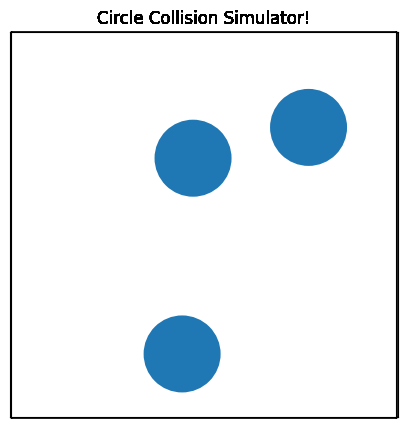

In [379]:
# create a list for the input to Simulation class
circle_list = [(Circle(rad,pos,dir)) for rad,pos,dir in zip(circle_radii,circle_positions,circle_directions)]
# create a simulation object for the Animation2D class
sim = Simulation(circle_list)


anim = Animation2D(sim).animate(interval=interval)